In [2]:
!pip install pillow
!pip install numpy
!pip install -U scikit-learn
!python -m pip install "tensorflow<2.11"

# Libraries

In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import Library as mylib
from Library import CustomDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

In [ ]:
# creazione dataset
path='../SubDataset'
name='TOY'
mylib.create_df_ipcv_diode(path,name='TOY')

In [ ]:
# creazione dataset
path='F:/Datasets/DIODE_FULL'
mylib.create_df_ipcv_diode(path)

# Split dataset

In [ ]:
csv_path="../Csv/TOY.csv"
custom_dataset = CustomDataset(csv_path, test_size=0.3, random_state=42,perc_dataset=0.02)
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=5, shuffle=True)

In [ ]:
csv_path="../Csv/path_images.csv"
custom_dataset = CustomDataset(csv_path, test_size=0.3, random_state=42,perc_dataset=0.02)
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=5, shuffle=True)

Element load :  43


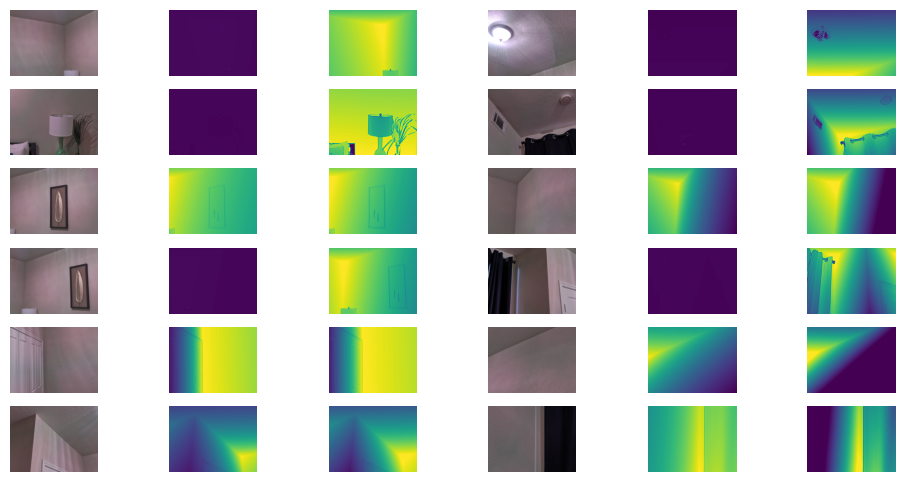

In [ ]:
mylib.print_dataset(train_loader,6,6,0)

In [ ]:
def print_union_dataset(train_loader,rows = 6,cols = 6,offset=12):
    fig, axs = plt.subplots(rows, cols, figsize=(12,6))
    axs = axs.flatten()
    i=0
    for index in range(0,rows*cols*16,4):
        image=train_loader.dataset.X_train_rgb[offset+index]
        mask=train_loader.dataset.y_train_depth[offset+index]

        ab = np.concatenate((train_loader.dataset.X_train_rgb[offset+index], train_loader.dataset.X_train_rgb[offset+index+1]), axis=1)
        cd = np.concatenate((train_loader.dataset.X_train_rgb[offset+index+2], train_loader.dataset.X_train_rgb[offset+index+3]), axis=1)
        result_Image = np.concatenate((ab, cd), axis=0)

        axs[i].imshow(result_Image)
        axs[i].axis('off')

        ab = np.concatenate((train_loader.dataset.y_train_rgbds[offset+index], train_loader.dataset.y_train_rgbds[offset+index+1]), axis=1)
        cd = np.concatenate((train_loader.dataset.y_train_rgbds[offset+index+2], train_loader.dataset.y_train_rgbds[offset+index+3]), axis=1)
        result_RGBDS = np.concatenate((ab, cd), axis=0)

        i+=1
        axs[i].imshow(result_RGBDS)
        axs[i].axis('off')
        i+=1
        
    # Mostra il plot
    plt.show()

IndexError: index 12 is out of bounds for axis 0 with size 12

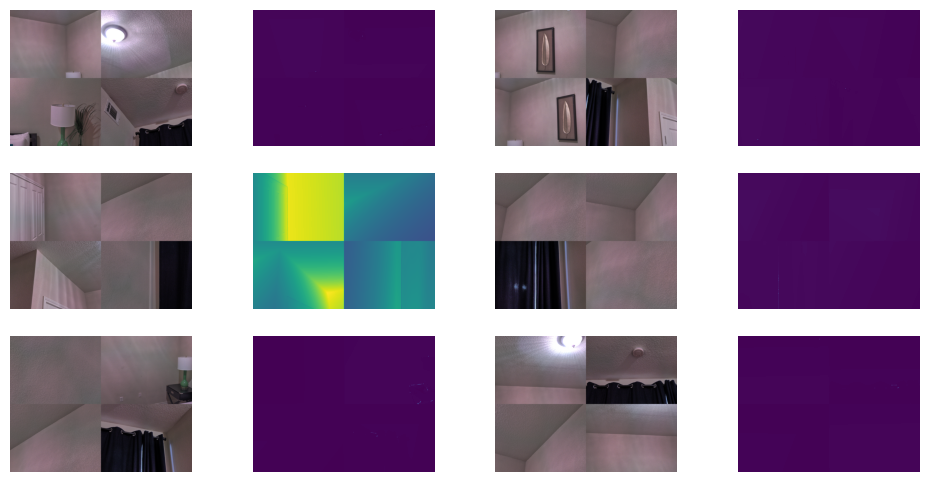

In [ ]:
print_union_dataset(train_loader,3,4,0)

# Model

In [ ]:
class ImageConverter(nn.Module):
    def __init__(self):
        super(ImageConverter, self).__init__()
        self.encoder = nn.Sequential( # Encoder
            # una convoluzione 2D con un kernel di dimensione 3x3, stride 1 e padding 1 che riceve in input immagini RGB con 3 canali e produce 32 feature map di output.
            nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential( # Decoder
            # una convoluzione trasposta 2D con un kernel di dimensione 3x3, stride 2, padding 1 e output padding 1 che riceve in input feature map di dimensioni ridotte prodotte dall'encoder e produce 64 feature map di output.
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
model = ImageConverter()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataset =custom_dataset
num_epochs = 5
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Functions